In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import os

In [30]:
def load_data(picNums):
    df = pd.read_csv('negs.csv')
    os.chdir('films')
    lst = []
    for i in range(picNums):
        img = cv.imread(str(i+1)+".jpeg")
        lst.append(img)
    df['pictures']=lst
    os.chdir('..')
    return df

In [31]:
total = 494
df = load_data(total)
print(df)

      picture  normal                                           pictures
0      1.jpeg       0  [[[16, 38, 79], [16, 38, 79], [15, 37, 78], [1...
1      2.jpeg       1  [[[0, 34, 87], [0, 37, 90], [0, 40, 93], [0, 4...
2      3.jpeg       0  [[[47, 42, 63], [47, 42, 63], [47, 42, 63], [4...
3      4.jpeg       1  [[[58, 67, 101], [58, 67, 101], [57, 66, 100],...
4      5.jpeg       0  [[[70, 77, 97], [70, 77, 97], [70, 77, 97], [7...
..        ...     ...                                                ...
489  490.jpeg       1  [[[1, 31, 58], [3, 33, 60], [7, 37, 64], [11, ...
490  491.jpeg       1  [[[15, 36, 67], [16, 37, 68], [17, 38, 69], [1...
491  492.jpeg       1  [[[64, 121, 166], [57, 114, 159], [51, 106, 15...
492  493.jpeg       1  [[[6, 46, 75], [8, 48, 77], [11, 51, 80], [13,...
493  494.jpeg       1  [[[14, 68, 103], [16, 70, 105], [18, 72, 105],...

[494 rows x 3 columns]


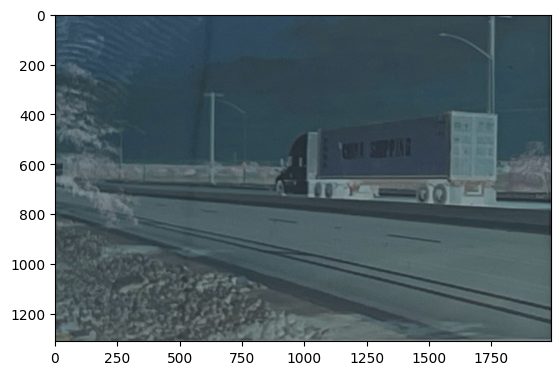

In [32]:
plt.imshow(df['pictures'][472])

In [33]:
normal = sum([1 for i in df['normal'] if i == 1])
normal

360

In [34]:
abnormal_rate = sum([1 for i in df['normal'] if i == 0]) / total
abnormal_rate

0.27125506072874495

In [35]:
from torchvision import transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [36]:
# https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=train_transform, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, idx

In [37]:
dataset = CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films')

In [38]:
dataset[472]

(tensor([[[-0.2856, -0.8678, -0.7822,  ..., -0.2856, -0.2342, -0.2856],
          [-0.2513, -0.8678, -0.7650,  ..., -0.3541, -0.3712, -0.4739],
          [-0.2342, -0.8678, -0.7650,  ..., -0.3883, -0.3883, -0.5424],
          ...,
          [-0.5596, -0.5424, -0.5253,  ..., -0.6109, -0.6281, -0.5767],
          [-0.1999, -0.3712, -0.3541,  ..., -0.4226, -0.4397, -0.4568],
          [ 0.2624,  0.2624,  0.2967,  ..., -0.2513, -0.2684, -0.3027]],
 
         [[-0.2150, -0.8627, -0.7752,  ..., -0.4776, -0.4426, -0.4426],
          [-0.1975, -0.8627, -0.7752,  ..., -0.5301, -0.5826, -0.6352],
          [-0.1975, -0.8627, -0.7752,  ..., -0.5651, -0.5826, -0.7052],
          ...,
          [-0.4426, -0.4426, -0.4251,  ..., -0.3550, -0.3725, -0.3200],
          [-0.0574, -0.2850, -0.2675,  ..., -0.1625, -0.1800, -0.2150],
          [ 0.3627,  0.3102,  0.3452,  ..., -0.0399, -0.0574, -0.0924]],
 
         [[-0.2358, -0.9156, -0.8633,  ..., -0.6715, -0.6367, -0.6541],
          [-0.2184, -0.9156,

In [39]:
dataset.__len__()

494

In [40]:
from torch.utils.data import DataLoader, random_split, Subset

val_size, train_size = total // 4, total - total // 4
training_data, test_data = random_split(dataset, [train_size, val_size])

train_ds = Subset(CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films',transform=train_transform), training_data.indices)
test_ds = Subset(CustomImageDataset('negs.csv','/Users/patrickdeng/Documents/film project/films',transform=test_transform), test_data.indices)

BATCH_SIZE = 36
SEED = 42

g = torch.Generator()
g.manual_seed(SEED)
training_data = DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True,generator=g)
test_data = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,generator=g)


In [41]:
training_data.__len__()

11

In [42]:
test_data.__len__()

4

In [43]:
import torch.nn.functional as F

In [44]:
class ResBlk(nn.Module):
    def __init__(self,numChannels,kernel=3,stride=1,padding=1,bypass=True):
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels=numChannels,kernel_size=kernel,stride=stride,padding=padding,bias=False)
        self.conv2 = nn.LazyConv2d(out_channels=numChannels,kernel_size=kernel,stride=1,padding=1,bias=False)
        self.conv3 = nn.Identity()
        if bypass:
            self.conv3 = nn.Sequential(
                nn.LazyConv2d(out_channels=numChannels,kernel_size=1,stride=stride,bias=False),
                nn.LazyBatchNorm2d()
            )
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [45]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.LazyLinear(1)
        self.model = nn.Sequential(
            nn.LazyConv2d(out_channels=64,kernel_size=7,stride=2,padding=1,bias=False),
            nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=3),
            ResBlk(numChannels=64,kernel=3,bypass=False),
            ResBlk(numChannels=64,kernel=3,bypass=False),
            ResBlk(numChannels=128,kernel=3,bypass=True),
            ResBlk(numChannels=128,kernel=3,bypass=False),
            ResBlk(numChannels=256,kernel=3,bypass=True),
            ResBlk(numChannels=256,kernel=3,bypass=False),
            ResBlk(numChannels=512,kernel=3,bypass=True),
            ResBlk(numChannels=512,kernel=3,bypass=False),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self,X):
        return self.fc(self.model(X).flatten(1))

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
EPOCHES = 10
model = ResNet18()
LR = 3e-4
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer,patience=2,factor=0.5,eps=1e-6)
#scheduler = CosineAnnealingLR(optimizer, T_max = EPOCHES)
from sklearn.metrics import f1_score

In [47]:
def test(epoches,LR,optimizer,scheduler):
    neg = abnormal_rate
    pos = 1 - neg
    accu = []
    train_loss_set = []
    val_loss_set = []
    lr_set = []
    f1score = []
    criterion = BCEWithLogitsLoss()
    for epoch in range(epoches):
        lr = optimizer.param_groups[0]['lr']
        lr_set.append(lr)
        model.train()
        train_loss = 0
        for (images, labels, index) in training_data:
            labels = labels.float().unsqueeze(1)
            logits = model(images)
            loss = criterion(logits, labels.float())
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_set.append(train_loss / len(training_data))
        model.eval()
        with torch.no_grad():
            total, correct = 0,0
            all_labels = []
            all_preds = []
            val_loss = 0
            f1 = 0
            for (images, labels, index) in test_data:
                outputs = model(images)
                probs = F.sigmoid(outputs)
                preds = (probs >= 0.5).float().view(-1)
                labels = labels.long().view(-1)
                val_loss += criterion(outputs, labels.float().unsqueeze(1))
                total += len(labels)
                correct += sum(preds == labels)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                f1 += f1_score(labels,preds)
            average_val_loss = val_loss / len(test_data)
            val_loss_set.append(average_val_loss)
            average_f1 = f1 / len(test_data)
            f1score.append(average_f1)
            scheduler.step(average_val_loss)
            #scheduler.step()
            acc = correct / total
            accu += [acc]
            print(f"epoch: {epoch+1}, accuracy rate: {(acc*100):.3f}%, train loss: {train_loss_set[-1]:.3f}, val loss: {val_loss_set[-1]:.3f}, learning rate: {lr:.7f}, f1 score: {average_f1:.3f}")
            if (epoch + 1) % 2 == 0:
                print("Confusion matrix")
                ConfusionMatrixDisplay.from_predictions(all_labels,all_preds)
                plt.show()
    return accu, train_loss_set, val_loss_set, lr_set, f1score

epoch: 1, accuracy rate: 72.358%, train loss: 0.662, val loss: 0.637, learning rate: 0.0003000, f1 score: 0.788
epoch: 2, accuracy rate: 43.902%, train loss: 0.498, val loss: 0.844, learning rate: 0.0003000, f1 score: 0.362
Confusion matrix


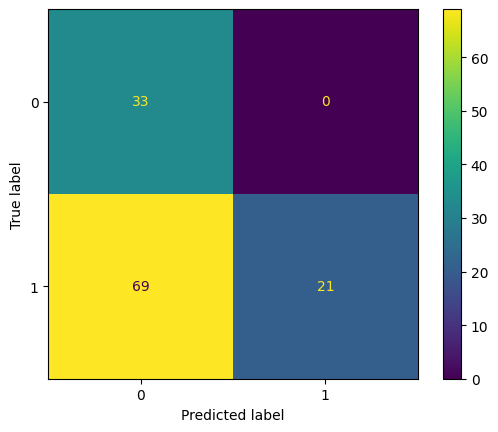

epoch: 3, accuracy rate: 56.098%, train loss: 0.488, val loss: 0.887, learning rate: 0.0003000, f1 score: 0.593
epoch: 4, accuracy rate: 81.301%, train loss: 0.441, val loss: 0.473, learning rate: 0.0003000, f1 score: 0.861
Confusion matrix


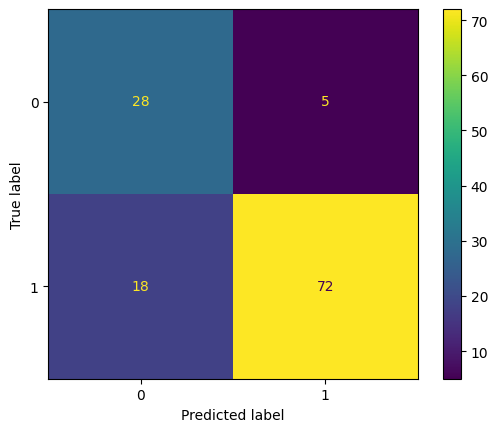

epoch: 5, accuracy rate: 77.236%, train loss: 0.413, val loss: 0.514, learning rate: 0.0003000, f1 score: 0.827
epoch: 6, accuracy rate: 86.992%, train loss: 0.437, val loss: 0.340, learning rate: 0.0003000, f1 score: 0.924
Confusion matrix


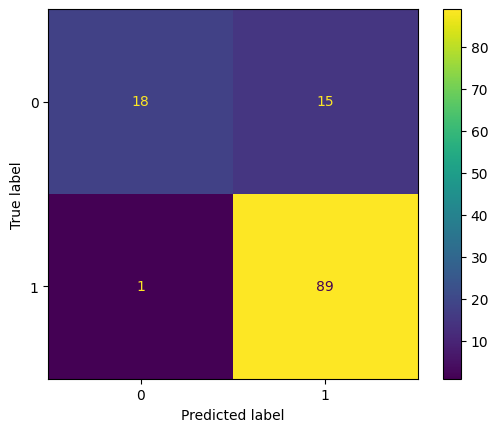

epoch: 7, accuracy rate: 79.675%, train loss: 0.444, val loss: 0.408, learning rate: 0.0003000, f1 score: 0.875
epoch: 8, accuracy rate: 84.553%, train loss: 0.419, val loss: 0.384, learning rate: 0.0003000, f1 score: 0.907
Confusion matrix


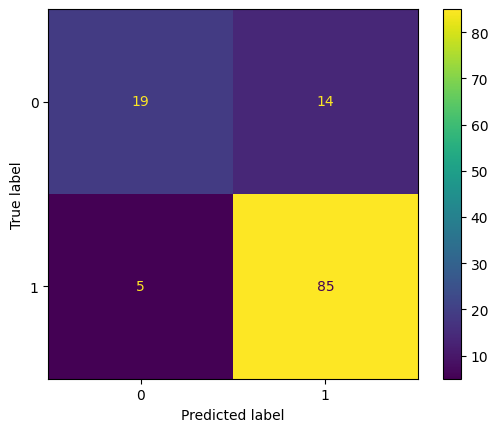

epoch: 9, accuracy rate: 82.114%, train loss: 0.416, val loss: 0.364, learning rate: 0.0003000, f1 score: 0.889
epoch: 10, accuracy rate: 82.114%, train loss: 0.355, val loss: 0.382, learning rate: 0.0001500, f1 score: 0.883
Confusion matrix


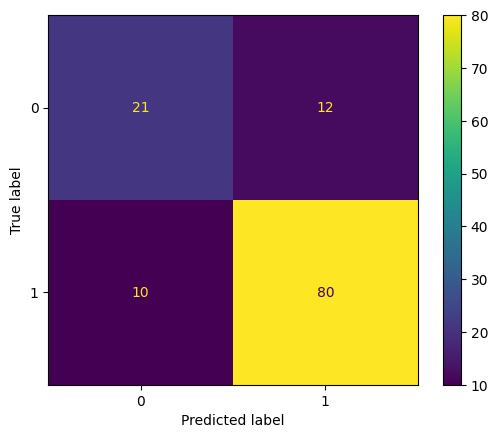

In [48]:
accu, train_loss, val_loss, lrs, f1score = test(EPOCHES,LR,optimizer,scheduler)

In [49]:
print(len(accu))
print(len(train_loss))
print(len(val_loss))
print(len(lrs))
print(len(f1score))

10
10
10
10
10


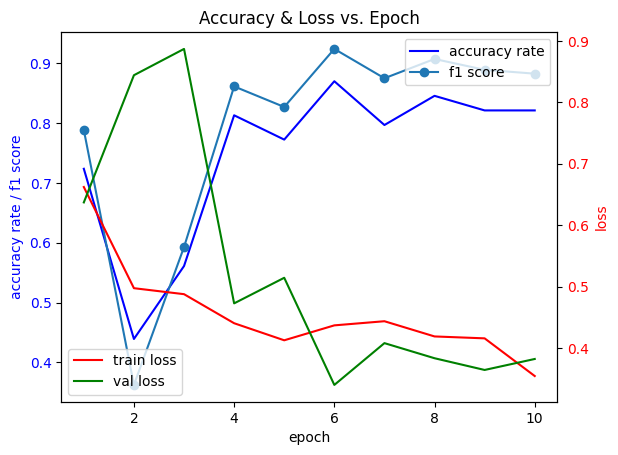

In [50]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,EPOCHES+1), accu, 'b-', label='accuracy rate')
ax1.plot(range(1,EPOCHES+1), f1score, 'o-', label='f1 score')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy rate / f1 score',color='b')
ax1.tick_params(axis='y',labelcolor='b')


ax2 = ax1.twinx()
ax2.plot(range(1,EPOCHES+1), [i.detach().numpy() for i in train_loss], 'r-',label='train loss')
ax2.plot(range(1,EPOCHES+1), [i.detach().numpy() for i in val_loss], 'g-',label='val loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss', color='r')
ax2.tick_params(axis='y',labelcolor='r')


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(loc='upper right')

ax2.legend(loc='lower left')
plt.title('Accuracy & Loss vs. Epoch')
plt.show()

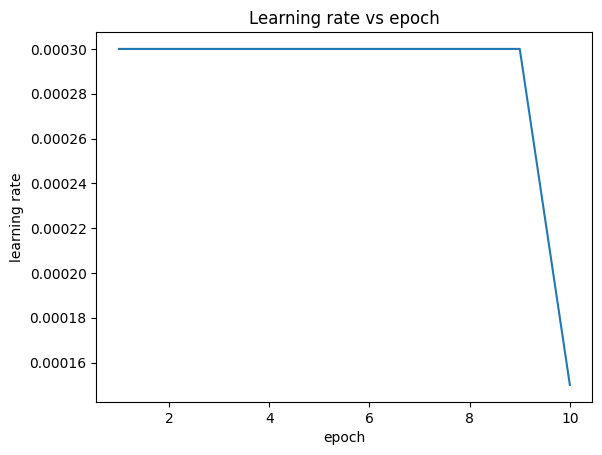

In [51]:
plt.plot(range(1,EPOCHES+1), lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("Learning rate vs epoch")
plt.show()

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def wrong_results(model, dataset):
    model.eval()
    wrong_images = []
    wrong_labels = []
    wrong_preds = []
    y_true = []
    y_preds = []
    wrong_indices = []
    with torch.no_grad():
        for (images, labels, indices) in test_data:
            outputs = model(images)
            probs = F.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            y_preds.extend(preds)
            y_true.extend(labels)
            wrongidx = [indices[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]]
            wrong_indices.extend(wrongidx)
            wrong_labels.extend([labels[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])
            wrong_preds.extend([preds[idx] for idx in range(len(labels)) if labels[idx] != preds[idx]])
            for idx in wrongidx:
                wrong_images.append(df['pictures'][idx.numpy().item()])
        BATCHSIZE = 36
        print(f'mistakes: {len(wrong_labels)} out of {len(y_preds)}')
        print(f'accuracy rate: {accuracy_score(y_true,y_preds)*100:.3f}%')
        print(f'f1 rate: {f1_score(y_true,y_preds)*100:.3f}%')
        print(f'precision rate: {precision_score(y_true,y_preds)*100:.3f}%')
        print(f'recall rate: {recall_score(y_true,y_preds)*100:.3f}%')
        ConfusionMatrixDisplay.from_predictions(np.array(y_true), np.array(y_preds))
        plt.show()
        return wrong_indices, wrong_images, wrong_labels, wrong_preds

mistakes: 22 out of 123
accuracy rate: 82.114%
f1 rate: 87.912%
precision rate: 86.957%
recall rate: 88.889%


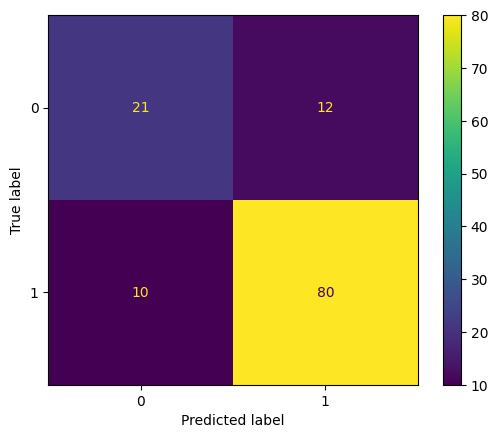

#275 The image is normal but was predicted as abnormal


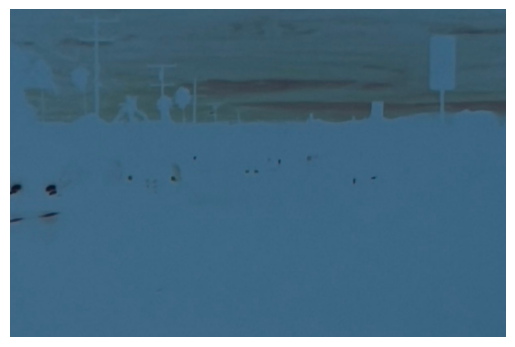

#449 The image is abnormal but was predicted as normal


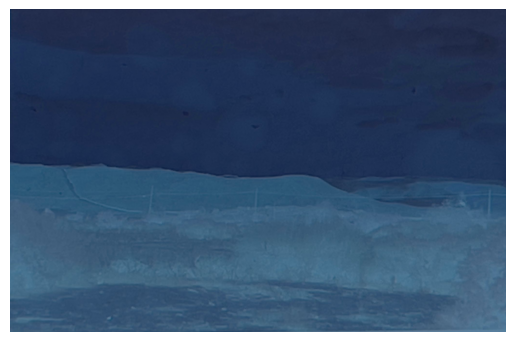

#415 The image is abnormal but was predicted as normal


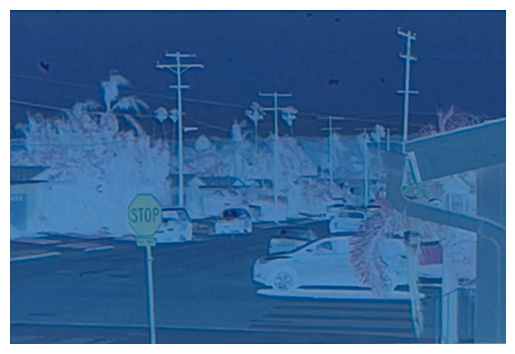

#330 The image is normal but was predicted as abnormal


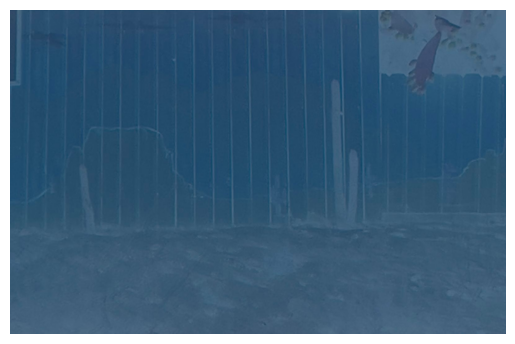

#427 The image is abnormal but was predicted as normal


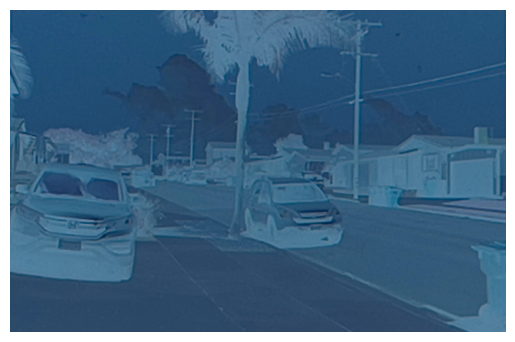

#263 The image is abnormal but was predicted as normal


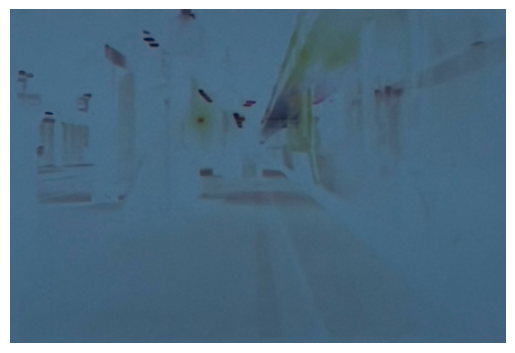

#425 The image is abnormal but was predicted as normal


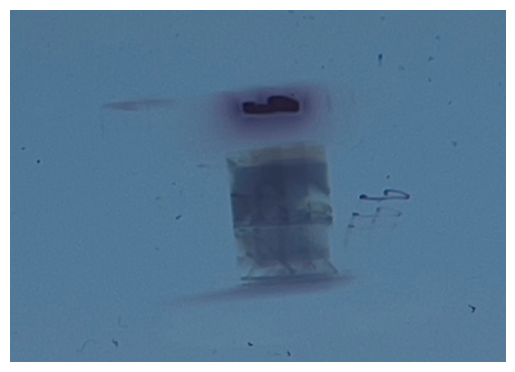

#207 The image is abnormal but was predicted as normal


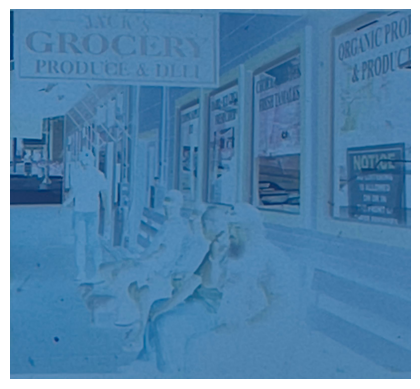

#147 The image is normal but was predicted as abnormal


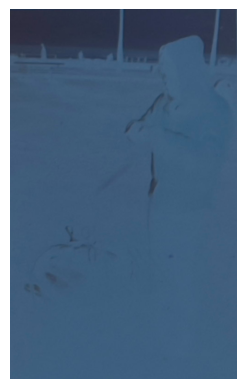

#435 The image is normal but was predicted as abnormal


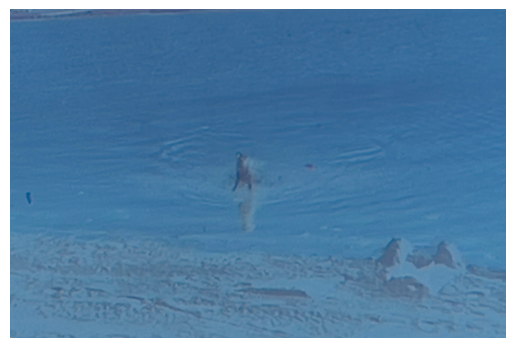

#7 The image is abnormal but was predicted as normal


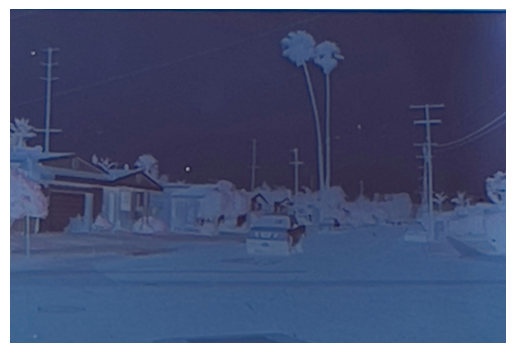

#141 The image is normal but was predicted as abnormal


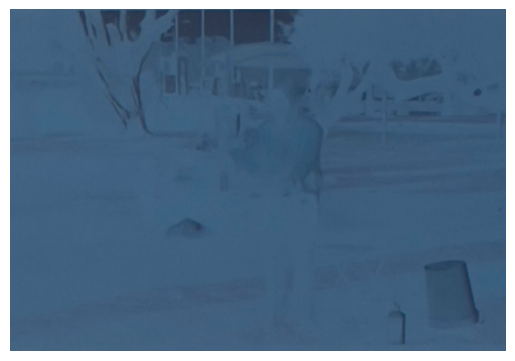

#163 The image is abnormal but was predicted as normal


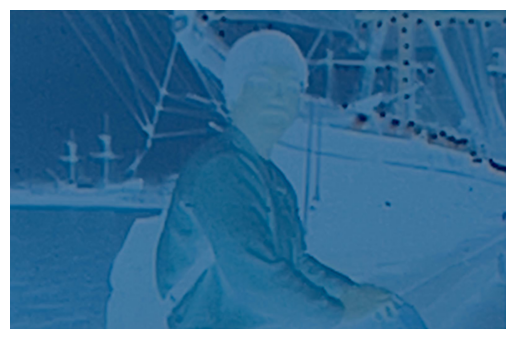

#192 The image is abnormal but was predicted as normal


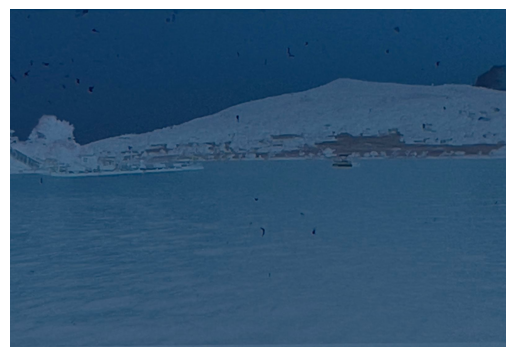

#273 The image is normal but was predicted as abnormal


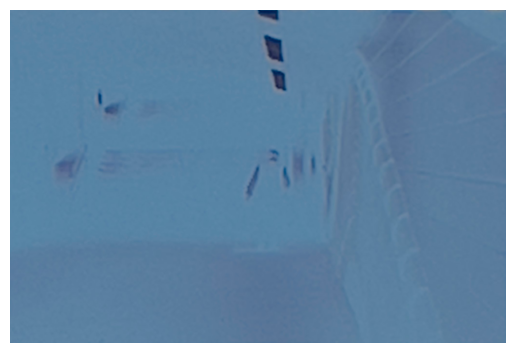

#8 The image is abnormal but was predicted as normal


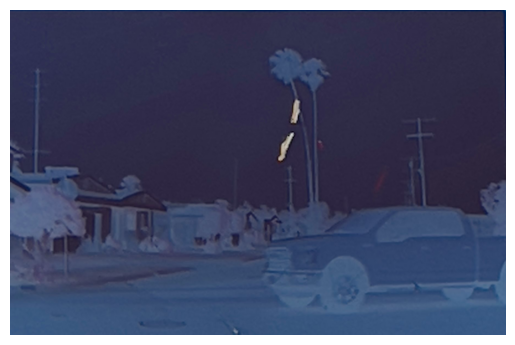

#432 The image is abnormal but was predicted as normal


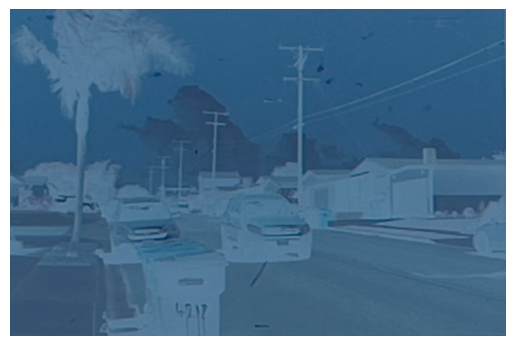

#238 The image is normal but was predicted as abnormal


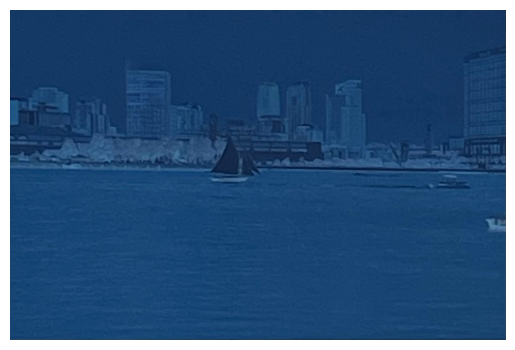

#142 The image is normal but was predicted as abnormal


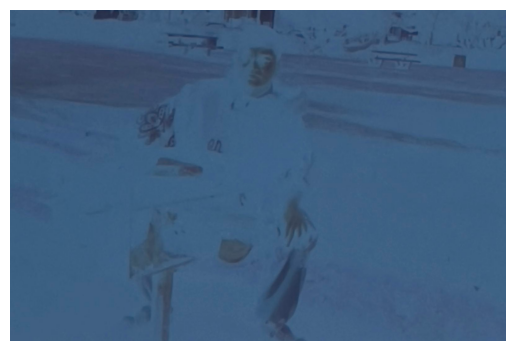

#403 The image is normal but was predicted as abnormal


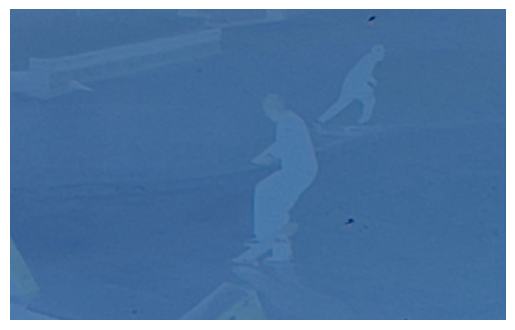

#258 The image is abnormal but was predicted as normal


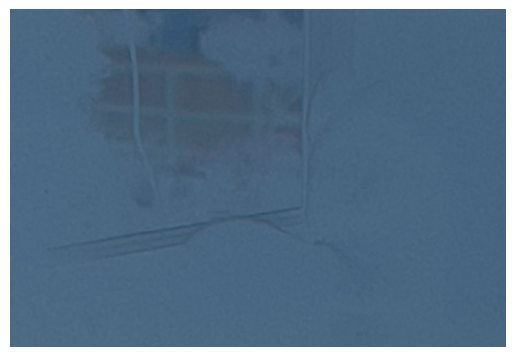

#137 The image is normal but was predicted as abnormal


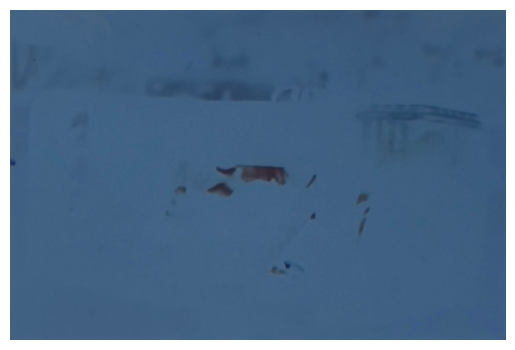

In [66]:
wrong_idx, wrong_images, wrong_labels, wrong_preds = wrong_results(model,dataset)

for idx, im, lb, pd in zip(wrong_idx, wrong_images, wrong_labels, wrong_preds):
    print(f'#{idx+1} The image is {'normal' if lb == 1 else 'abnormal'} but was predicted as {'normal' if pd >= 0.5 else 'abnormal'}')
    plt.imshow(im)
    plt.axis('off')
    plt.show()

